In [2]:
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import seaborn as sns
from scipy.signal import butter,filtfilt,welch
from scipy import signal
import optuna
import numpy as np  
import optuna.visualization as vis
from optuna.pruners import MedianPruner
import plotly
from scipy.stats import chisquare

/usr/lib/python3/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
low_cutoff = 0.01  # Low cut-off frequency (Hz)
high_cutoff = 70.0  # High cut-off frequency (Hz)
order = 4  # Order of the filter
sampling_rate_equipo= 500 
b, a = signal.butter(order, [low_cutoff / (0.5 * sampling_rate_equipo), high_cutoff / (0.5 * sampling_rate_equipo)], btype='band')

In [4]:
fs = 500  # Sampling rate
nperseg = 256  # Segment length
noverlap = 128 # Overlap between segments
sampling_rate = 2000 ### simulacion 

resultado_compilacion = subprocess.run("g++ -fopenmp -O3 main.cpp Matrix_conect.cpp -o main", shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
if resultado_compilacion.returncode != 0:
    print("Error durante la compilación:")
    print(resultado_compilacion.stderr)

def Simulado_EGG(params):
    L, P, inhibidoras, trest, trelative, alpha, tmax, type_matrix = params
        
    # Ejecución del programa
    resultado_ejecucion = subprocess.run(f"./main {L} {P} {inhibidoras} {trest} {trelative} {alpha} {tmax} {type_matrix}", shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    if resultado_ejecucion.returncode != 0:
        print("Error durante la ejecución:")
        print(resultado_ejecucion.stderr)
        return None
    
    # Procesamiento de los datos
    lines = resultado_ejecucion.stdout.strip().split('\n')
    data_list = [[float(num) for num in line.split()] for line in lines]
    data = np.array(data_list)[30:, 1]
    
    data=(data) / np.max(data)  ### valor maximo
    # #data=(data - np.min(data)) / (np.max(data) - np.min(data)) ### min-max
    # data=(data - np.mean(data)) / np.std(data)
    
    n_samples_resampled = int(len(data)*(fs/sampling_rate))
    data_resampled = signal.resample(data, n_samples_resampled)

    butter = signal.filtfilt(b, a,data_resampled)

    frequencies, psd = signal.welch(butter, fs, nperseg=nperseg, noverlap=noverlap)
    frequencies=np.array(frequencies)


    welch_data = np.array([10 * np.log10(psd[i]) for i in range(len(frequencies))])
    
    delta = welch_data[np.logical_and(frequencies >= 0, frequencies <= 3)]
    theta = welch_data[np.logical_and(frequencies >= 3, frequencies <= 7)]
    alpha = welch_data[np.logical_and(frequencies >= 7, frequencies <= 14)]
    beta = welch_data[np.logical_and(frequencies >= 14, frequencies <= 30)]

    return {
        'data': data,"data_resample":data_resampled,"butter": butter,
        "frequencies": frequencies,"welch_data":welch_data,
        'delta':[delta.mean(),delta.std()],
        'theta':[theta.mean(), theta.std()],
        'alpha':[ alpha.mean(),alpha.std()],
        'beta': [beta.mean(), beta.std()]
    }



# Datos Reales

 Tanto como los datos reales como lo simulados pueden ser normlaizados(por su maximo), los valores real estan en microvoltios, en la simulacion estan con 0.00070 microvoltios reposo 

In [5]:
def Datos_reales(nombres):
    Datos = np.empty(len(nombres), dtype=object)
    Butter = np.empty(len(nombres), dtype=object)
    welch_datos = np.empty(len(nombres), dtype=object)
    Frequencies = np.empty(len(nombres), dtype=object)
    Delta = np.empty(len(nombres), dtype=object)
    Theta = np.empty(len(nombres), dtype=object)
    Alpha = np.empty(len(nombres), dtype=object)
    Beta = np.empty(len(nombres), dtype=object)
    Nombres=np.empty(len(nombres), dtype="U100")

    # Inicialización de arrays para promedios de bandas
    main_welch=np.zeros(129)
    main_Delta = np.zeros(2)
    main_Theta = np.zeros(2)
    main_Alpha = np.zeros(2)
    main_Beta = np.zeros(2)
    for i, nombre in enumerate(nombres):  
        Nombres[i]=nombre 


        data = np.loadtxt(nombre)
        data=(data) / np.max(data)  ### valor maximo
        # #data=(data - np.min(data)) / (np.max(data) - np.min(data)) ### min-max
        # data=(data - np.mean(data)) / np.std(data)
        Datos[i]=data

        Butter[i]=butter= signal.filtfilt(b, a,data)

        frequencies, psd = signal.welch(butter, fs, nperseg=nperseg, noverlap=noverlap)
        Frequencies[i]=frequencies=np.array(frequencies)

        welch_data = np.array([10 * np.log10(psd[i]) for i in range(len(frequencies))])
        welch_datos[i]=welch_data
        main_welch+=welch_data/len(nombres)

        delta = welch_data[np.logical_and(frequencies >= 1, frequencies <= 3)]
        theta = welch_data[np.logical_and(frequencies >= 4, frequencies <= 7)]
        alpha = welch_data[np.logical_and(frequencies >= 7, frequencies <= 13)]
        beta = welch_data[np.logical_and(frequencies >= 14, frequencies <= 30)]

        Delta[i]=[delta.mean(),delta.std()]
        Theta[i]=[theta.mean(),theta.std()]
        Alpha[i]=[alpha.mean(),alpha.std()]
        Beta[i]=[beta.mean(),beta.std()]

        main_Delta += np.array([delta.mean(), delta.std()]) / len(nombres)
        main_Theta += np.array([theta.mean(), theta.std()]) / len(nombres)
        main_Alpha += np.array([alpha.mean(), alpha.std()]) / len(nombres)
        main_Beta += np.array([beta.mean(), beta.std()]) / len(nombres)

    return {
        "Nombres":Nombres,
        'datos': Datos,"buter":Butter, "frequencies": Frequencies,  "welch_data":welch_datos,"main_welch":main_welch,
        'delta':Delta,'theta':Theta,'alpha':Alpha,'beta':Beta,
        'main_Delta': main_Delta,'main_Theta':main_Theta,"main_Alpha":main_Alpha,"main_Beta":main_Beta
    }


In [10]:
Params={'L': 29, 'P': 0.3495855264639949, 'Inh': 0.4374925488997701, 'Trest': -5.413378622682971, 'Trelative': 4.30925916893512, 'C_h': 26.897198730686277, 'Tipo_red': 2}
initial_params = [Params["L"], Params["P"],Params["Inh"], Params["Trest"],Params["Trelative"], Params["C_h"] ,8030,Params["Tipo_red"]]
generated_data = Simulado_EGG(initial_params)
reales_total = Datos_reales(["P3_MNE.txt","Pz_MNE.txt","P4_MNE.txt"])

['P3_MNE.txt' 'Pz_MNE.txt' 'P4_MNE.txt']


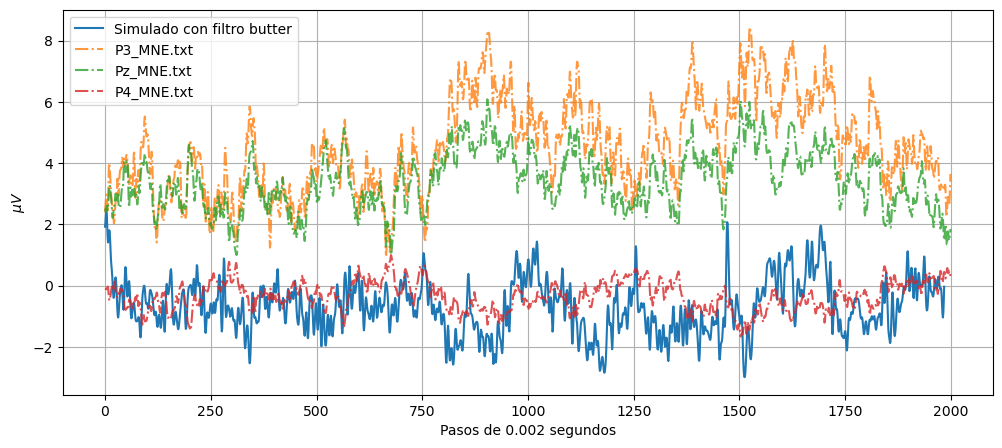

In [13]:
fig, ax = plt.subplots(figsize=[12, 5])

print(reales_total["Nombres"])
#ax.plot(generated_data["data_resample"],label="Simulado")
ax.plot(generated_data["butter"][15:],label="Simulado con filtro butter")
for i in range(3):
    ax.plot(reales_total["datos"][i],"-.", label=reales_total["Nombres"][i],alpha=0.8)


plt.xlabel("Pasos de 0.002 segundos")
plt.ylabel(r"$\mu V$")
plt.legend()  # Esto añade una leyenda para identificar cada línea
plt.grid()
plt.show()  # Mostrar todos los gráficos en la misma figura


hi_squere=3.004603204485719
['P3_MNE.txt' 'Pz_MNE.txt' 'P4_MNE.txt']
Delta [-12.874801256368574, 1.889727087028703] ---- [-12.92827306   0.        ]
Theta [-14.58597293554347, 1.2166810577955838] ---- [-16.72324732   0.        ]
Alpha [-19.86155673391864, 1.1462502629131217] ---- [-18.38649744   1.28777275]
Beta [-24.113658682347577, 1.6232894392296107] ---- [-25.83153672   1.55043909]


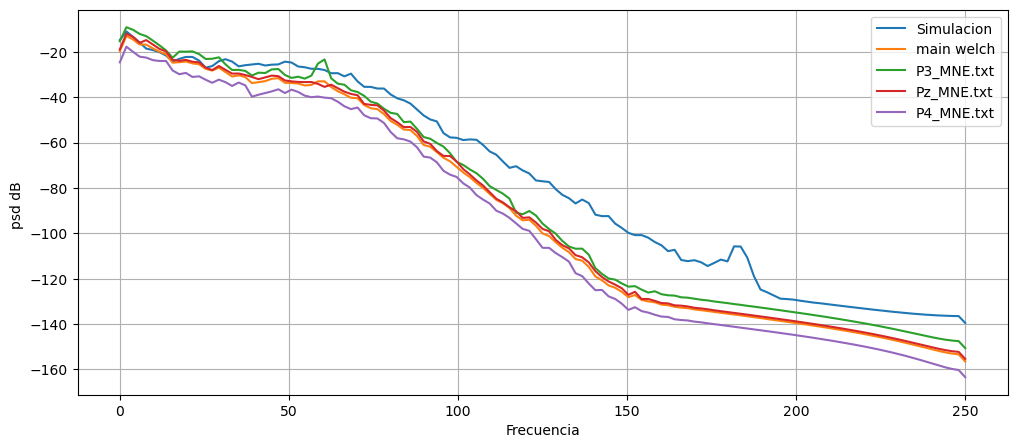

In [16]:
hi2_stat, p_value = chisquare(generated_data["welch_data"][:16], f_exp=reales_total["main_welch"][:16])

print(f"hi_squere={abs(hi2_stat)}")
fig, ax = plt.subplots(figsize=[12, 5])

print(reales_total["Nombres"])
print("Delta",generated_data["delta"],"----",reales_total["main_Delta"])
print("Theta",generated_data["theta"],"----",reales_total["main_Theta"])
print("Alpha",generated_data["alpha"],"----",reales_total["main_Alpha"])
print("Beta",generated_data["beta"],"----",reales_total["main_Beta"])

ax.plot(generated_data["frequencies"],generated_data["welch_data"],label="Simulacion")
ax.plot(reales_total["frequencies"][0],reales_total["main_welch"],label="main welch")
for i in range(3):
    ax.plot(reales_total["frequencies"][i],reales_total["welch_data"][i], label=reales_total["Nombres"][i])

plt.xlabel("Frecuencia")
plt.ylabel("psd dB ")
# plt.xlim(0,120)
plt.grid()
plt.legend()  # Esto añade una leyenda para identificar cada línea
plt.show()  # Mostrar todos los gráficos en la misma figura


In [17]:

def objective(trial):
    params = np.zeros(8)
    params[0] = trial.suggest_int('L',20,45)
    params[1] = trial.suggest_float('P', 0.0, 1.0)
    params[2] = trial.suggest_float('Inh', 0.0, 1.0)
    params[3] = -3.887767671371372  #trial.suggest_float('Trest', -10.0, 10.0)###, step=0.05 difernecia entre datos 
    params[4] = trial.suggest_float('Trelative',params[3],params[3]+10)  
    params[5] = trial.suggest_float('C_h', 0, 50)
    params[6] = 8030
    params[7] = trial.suggest_int('Tipo_red',1,2)

    
    generated_data_total = Simulado_EGG(params)
    if generated_data_total["delta"][1]-generated_data_total["delta"][1]==0:
        ### ------------------ Por bandas
        # dif_Delta=generated_data_total["delta"]-reales_total["main_Delta"]
        # dif_Theta=generated_data_total["theta"]-reales_total["main_Theta"]
        # dif_Alpha=generated_data_total["alpha"]-reales_total["main_Alpha"]
        # dif_Beta=generated_data_total["beta"]-reales_total["main_Beta"]
        # difference = (np.sum(np.abs(dif_Delta)) +
        #                     np.sum(np.abs(dif_Theta)) +
        #                     np.sum(np.abs(dif_Alpha)) +
        #                     np.sum(np.abs(dif_Beta)))
        
        ### -------------------- Chi
        hi2_stat, p_value = chisquare(generated_data_total["welch_data"][:17], f_exp=reales_total["main_welch"][:17])
        trial.report(abs(hi2_stat), step=trial.number)### general
        
        
        return abs(hi2_stat)
    else:
        return float('inf') 
    
# Create and optimize the study
study = optuna.create_study(study_name='4bandas_SW_max_chi30_TR', 
                            storage='sqlite:///Estudios/small_world/chi2/4bandas_SW_max_chi30_TR.db', 
                            load_if_exists=True,pruner=MedianPruner())

# Continúa con la optimización del estudio
study.optimize(objective, n_trials=1000)


[I 2024-10-14 20:41:24,702] A new study created in RDB with name: 4bandas_SW_max_chi30_TR
[I 2024-10-14 20:41:25,427] Trial 0 finished with value: 1459.069682880492 and parameters: {'L': 33, 'P': 0.17837833753183974, 'Inh': 0.37444641077950835, 'Trelative': -1.088522637204509, 'C_h': 38.31023410450198, 'Tipo_red': 2}. Best is trial 0 with value: 1459.069682880492.
[I 2024-10-14 20:41:26,326] Trial 1 finished with value: 2417.0108670370223 and parameters: {'L': 27, 'P': 0.8023978796798691, 'Inh': 0.0667743763441715, 'Trelative': 3.2594631710360966, 'C_h': 14.346912840064647, 'Tipo_red': 1}. Best is trial 0 with value: 1459.069682880492.
[I 2024-10-14 20:41:30,053] Trial 2 finished with value: 171.63512625021286 and parameters: {'L': 42, 'P': 0.4406335008939749, 'Inh': 0.5822459901259923, 'Trelative': 4.501194990081484, 'C_h': 16.77911540786607, 'Tipo_red': 1}. Best is trial 2 with value: 171.63512625021286.
[I 2024-10-14 20:41:33,733] Trial 3 finished with value: 35.36106872545844 and p

In [18]:

print(study.study_name)
valid_trials = [t for t in study.trials if t.value is not None]
top_3_trials = sorted(valid_trials, key=lambda t: t.value)[:10]
for i, trial in enumerate(top_3_trials):
    print(f"\nTrial {i+1}:")
    print("Params:", trial.params)
    print("Value:", trial.value)
print("---------------------------------------","\n")
print("Best Result:", study.best_value)

vis.plot_optimization_history(study)


4bandas_SW_max_chi30_TR

Trial 1:
Params: {'L': 24, 'P': 0.24200155361712777, 'Inh': 0.6098373295922661, 'Trelative': 4.233883910666006, 'C_h': 17.68762534718209, 'Tipo_red': 2}
Value: 1.043241185172391

Trial 2:
Params: {'L': 28, 'P': 0.24691120401283564, 'Inh': 0.7275314142424159, 'Trelative': 5.130193667571176, 'C_h': 34.40554229894107, 'Tipo_red': 2}
Value: 1.4149496363229797

Trial 3:
Params: {'L': 28, 'P': 0.3971281908643216, 'Inh': 0.8593631067601418, 'Trelative': 4.959990521016742, 'C_h': 17.787472102472325, 'Tipo_red': 2}
Value: 1.8141477903379755

Trial 4:
Params: {'L': 26, 'P': 0.5187025396867425, 'Inh': 0.8322583899219207, 'Trelative': 4.919267084247856, 'C_h': 33.74262528653984, 'Tipo_red': 2}
Value: 1.881876649083834

Trial 5:
Params: {'L': 28, 'P': 0.2580702102276909, 'Inh': 0.82198542990977, 'Trelative': 4.099860518872486, 'C_h': 20.495210535310655, 'Tipo_red': 2}
Value: 1.899651534010361

Trial 6:
Params: {'L': 24, 'P': 0.18834345095454896, 'Inh': 0.6197386222234388, '

In [19]:
vis.plot_param_importances(study)

In [20]:
vis.plot_parallel_coordinate(study)

In [21]:
optuna.visualization.plot_slice(study)